In [80]:
import numpy as np
import qiskit.quantum_info
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer, transpile, assemble
import qiskit_ibm_provider
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit.quantum_info import random_statevector
import matplotlib.pyplot as plt

**We set up the registers and circuit object**

In [81]:
quantum_register = QuantumRegister(3, name="q")
classic_register_out = ClassicalRegister(1, name="out")
teleportation_circuit = QuantumCircuit(quantum_register,
                                       classic_register_out)

**Define the various steps of the algorithm in functions for better reuse.**

In [82]:
def add_bell_pair(qc: QuantumCircuit, a: int, b: int):
    qc.h(a)
    qc.cx(a,b)

In [83]:
def input_gates(qc: QuantumCircuit, to_teleport: int, a: int):
    qc.cx(to_teleport, a)
    qc.h(to_teleport)

In [84]:
def measure_and_send(qc: QuantumCircuit, a: int, b: int):
    qc.barrier()
    qc.measure(a, 0)
    qc.measure(b, 1)

In [85]:
def output_gates(qc: QuantumCircuit, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

**Now we actually construct the circuit**

In [86]:
psi = random_statevector(2)
display(array_to_latex(psi, prefix="|\\psi\\rangle = "))
init = Initialize(psi)
init.label = "Init"

<IPython.core.display.Latex object>

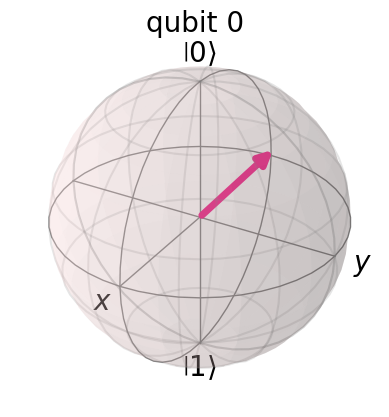

In [87]:
plot_bloch_multivector(psi)

In [88]:
teleportation_circuit.append(init, [0])
teleportation_circuit.barrier()
add_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.barrier()
input_gates(teleportation_circuit, 0, 1)
#measure_and_send(teleportation_circuit, 0, 1)
teleportation_circuit.barrier()
output_gates(teleportation_circuit, 0, 1, 2)
inverse_init = init.gates_to_uncompute()
teleportation_circuit.append(inverse_init, [2])
teleportation_circuit.measure(2,0)
teleportation_circuit.draw()

┌──────────────────────────────────────────┐ ░            ░      ┌───┐»
  q_0: ┤ Init(0.70231+0.62148j,-0.16252+0.30678j) ├─░────────────░───■──┤ H ├»
       └──────────────────────────────────────────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘»
  q_1: ─────────────────────────────────────────────░─┤ H ├──■───░─┤ X ├─────»
                                                    ░ └───┘┌─┴─┐ ░ └───┘     »
  q_2: ─────────────────────────────────────────────░──────┤ X ├─░───────────»
                                                    ░      └───┘ ░           »
out: 1/══════════════════════════════════════════════════════════════════════»
                                                                             »
«        ░                            
«  q_0: ─░───────■────────────────────
«        ░       │                    
«  q_1: ─░───■───┼────────────────────
«        ░ ┌─┴─┐ │ ┌──────────────┐┌─┐
«  q_2: ─░─┤ X ├─■─┤ disentangler ├┤M├
«        ░ └───┘   └──────────────┘└╥┘
«out: 1/════════════════════════════╩═
«                                   0

# Simulate

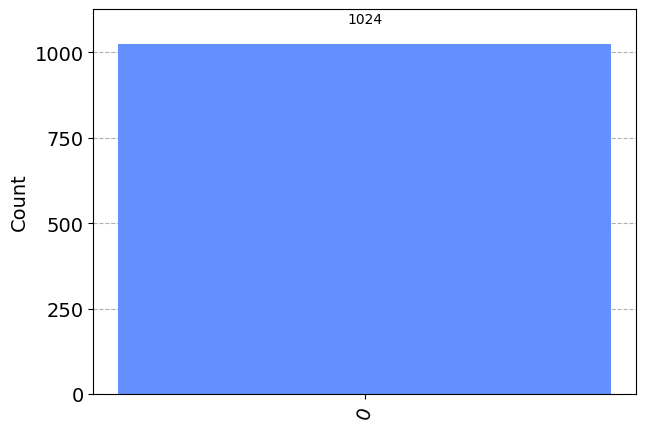

In [89]:
from qiskit.result import marginal_counts

simulator = Aer.get_backend("aer_simulator")
counts = simulator.run(transpile(teleportation_circuit, simulator)).result().get_counts()
output = marginal_counts(counts)
plot_histogram(output)

In [ ]:
from qiskit_ibm_provider.job import job_monitor
from qiskit_ibm_provider import IBMProvider

hub = "ibm-q-asu"
group = "main"
project = "pi-deluca"
hgp = f"{hub}/{group}/{project}"
backend = qiskit_ibm_provider.least_busy(IBMProvider(instance=hgp).backends(min_num_qubits=3, filters=lambda b: not b.configuration().simulator == True))
print(backend.name)
trans_gc = transpile(teleportation_circuit, backend, optimization_level=3)
job = backend.run(trans_gc)
job_monitor(job)

ibm_hanoi
Job Status: job is queued (2) [Est. wait time: 4 hrs 59 min]  

In [ ]:
results = job.result()
plot_histogram(results.get_counts(teleportation_circuit))